## FDW Crop Production Data Profiling - Malawi

In [1]:
import glob, json
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import requests
import numpy as np
import pandas as pd
import geopandas as gpd
from tools import save_npz, PrintAdminUnits, PlotAdminShapes
from tools import FDW_PD_Sweeper, FDW_PD_AvalTable, FDW_PD_Compiling, FDW_PD_ValidateFnidName
from tools import FDW_PD_CreateAdminLink, FDW_PD_RatioAdminLink, FDW_PD_ConnectAdminLink
from tools import FDW_PD_CaliSeasonYear
from tools_graphic import PlotBarProduction, PlotLinePAY
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
pd.options.mode.chained_assignment = None

In [2]:
# CPCV2 grain code ------------------------------ #
grain_code = pd.read_hdf('../data/crop/grain_cpcv2_code.hdf')
product_category = grain_code[['product', 'product_category']].set_index('product').to_dict()['product_category']
# ----------------------------------------------- #

# Load FEWS NET administrative boundaries ------- #
epsg = 'EPSG:32736' # Malawi
fn_shapes = sorted(glob.glob('../data/shapefile/fewsnet/MW_Admin?_????.shp'))
shape_all = []
for fn in fn_shapes:
    name = fn[-18:-4]
    exec('%s = gpd.read_file("%s").to_crs("%s")' % (name, fn, epsg))
    exec('%s["area"] = %s["geometry"].area/10**6' % (name, name))
    exec('shape_all.append(%s)' % (name))
shape_all = pd.concat(shape_all, axis=0).reset_index(drop=True)
PrintAdminUnits(shape_all)
# ----------------------------------------------- #

# FDW API host address -------------------------- #
host = 'https://fdw.fews.net'
auth = tuple(json.loads(open('token.json', "r").read()))
parameters = {
    'format': 'json',
    'country': 'Malawi',
    'product': ['R011','R012','R013','R014','R015','R016','R017','R018','R019'],
    'survey_type': 'crop:best',
    'status':'Collected' 
}
endpoint = '/api/cropproductionfacts/'
response = requests.get(host + endpoint, params=parameters, proxies={}, auth=auth)
response.raise_for_status()
df = pd.DataFrame.from_records(response.json())
df_origin = df.copy()
# ----------------------------------------------- #

- FEWS NET admin shapefiles ------------------- #
| year	 | Admin1   | # units   | Admin2   | # units   | Admin3   | # units   |
| 1971	 | MW1971A1 | 3	| MW1971A2	| 24	| nan	| 0	|
| 1998	 | MW1998A1 | 3	| MW1998A2	| 27	| nan	| 0	|
| 2003	 | MW2003A1 | 3	| MW2003A2	| 28	| nan	| 0	|
| 2018	 | MW2018A1 | 3	| MW2018A2	| 32	| nan	| 0	|
----------------------------------------------- #


In [3]:
# Manual Pre-processing before Sweeping --------- #

# 1. Default setting 
# a) None-type crop production system
df.loc[df['crop_production_system'].isna(), 'crop_production_system'] = 'none'
df.loc[df['crop_production_system'] == '', 'crop_production_system'] = 'none'
# b) None-type population group
df.loc[df['population_group'].isna(), 'population_group'] = 'none'
df.loc[df['population_group'] == '', 'population_group'] = 'none'

# 2. Manual setting
# a) Add admin names to reporting units
admin_level = 'admin_3'
reporting_unit = df.loc[df['fnid'].map(lambda x: x[6] != 'A'), 'fnid'].unique()
df.loc[df.fnid.isin(reporting_unit),admin_level] = df.loc[df.fnid.isin(reporting_unit), 'locality_name'].map(lambda x: x.split(' ')[0])

# b) remove minor crops for which there is only a few years of data
df = df.loc[~(np.isin(df['product'],['Pineapple (unspecified)', 'Pigeon pea (hybrid)', 'Papaya (unspecified)', 
                                    'Orange (unspecified)', 'Mango (unspecified)', 'Macadamia (unspecified)']))]

#c) remove the "estate" and "Estate (PS)" production systems
df = df.loc[~(np.isin(df['crop_production_system'],['Estate (PS)','estate']))]

#d) rename crops
df.loc[(df['product']=='Pigeon pea (Unspecified)'),'product'] = 'Pigeon Peas'
df.loc[(df['product']=='Coffee (unspecified)'),'product'] = 'Coffee (Unspecified)'

#e) drop seasons that are not the main season with only intermediate amounts of data
df = df.loc[~((df['product']=='Rice (Paddy)')&(df['season_name']=='Winter'))]
df = df.loc[~((df['product']=='Bambara groundnut')&(df['season_name']=='Winter'))]
df = df.loc[~((df['product']=='Cassava')&(df['season_name']=='Winter'))]
df = df.loc[~((df['product']=='Sesame Seed')&(df['season_name']=='Winter'))]
df = df.loc[~((df['product']=='Sunflower Seed')&(df['season_name']=='Winter'))]
df = df.loc[~((df['product']=='Soybean (unspecified)')&(df['season_name']=='Winter'))]
df = df.loc[~((df['product']=='Millet (Finger)')&(df['season_name']=='Winter'))]
df = df.loc[~((df['product']=='Groundnuts (In Shell)')&(df['season_name']=='Winter'))]
df = df.loc[~((df['product']=='Maize Grain (White)')&(df['season_name']=='Winter'))]
df = df.loc[~((df['product']=='Tobacco (Burley)')&(df['season_name']=='Winter'))]
df = df.loc[~((df['product']=='Cotton (Unspecified)')&(df['season_name']=='Winter'))]

df = df.loc[~((df['product']=='Cowpeas (Mixed)')&(df['season_name']=='Main'))]
df = df.loc[~((df['product']=='Wheat Grain')&(df['season_name']=='Main'))]

#f) drop some of the subcrops to keep the dominant type
df = df.loc[~((df['product']=='Tobacco (Flue-Cured)'))]
df = df.loc[~((df['product']=='Tobacco (NDDF)'))]
df = df.loc[~((df['product']=='Tobacco (SDDF)'))]
df = df.loc[~(df['product']=='Tobacco (Oriental)')]

#drop 2019 for Burley Tobacco as this value needs to be corrected
df = df.loc[~((df['product']=='Tobacco (Burley)')&(df['season_year']=='Main 2019'))]

# ----------------------------------------------- #

# FDW Production Data Inspection ---------------- #
df, df_raw = FDW_PD_Sweeper(df, area_priority="Area Planted")
table_dict = FDW_PD_AvalTable(df, shape_all)
# ----------------------------------------------- #

# FEWS NET Shapefile comparison ----------------- #
shape_used = pd.concat([MW_Admin2_1971, MW_Admin2_1998, MW_Admin2_2003], axis=0)
PlotAdminShapes(shape_used, label=True)
# ----------------------------------------------- #

- Remove missing records ---------------------- #
Orignial data points: 29,782
10,178/10,178 "Area Planted" points are retained.
9,802/9,802 "Quantity Produced" points are retained.
9,802/9,802 "Yield" points are retained.
Current data points: 29,782

- Minor changes are applied ------------------- #

- Basic information --------------------------- #
Data period: 1982 - 2019
29 grain types are found: Bambara groundnut, Banana (unspecified), Bean (Hyacinth), Beans (Pinto), Beans (mixed), Cassava, Chick Peas, Chili pepper (Unspecified), Coffee (Unspecified), Cotton (Unspecified), Cowpeas (Mixed), Field Peas, Groundnuts (In Shell), Maize Grain (White), Millet, Millet (Finger), Millet (Pearl), Pigeon Peas, Potato (Irish), Rice (Paddy), Sesame Seed, Sorghum, Soybean (unspecified), Sunflower Seed, Sweet Potatoes, Tangerine, Tobacco (Burley), Velvet bean, Wheat Grain
2 seasons are found: Winter (09-01), Main (04-01)
1 crop production system are found: none
Data sources include:
[1] Ministry o


- Malawi crop seasonal calendar

![FEWS NET](https://fews.net/sites/default/files/styles/large_width_880/public/2023-03/seasonal-calendar-malawi.png?itok=Vq_GZunP)

![image](../figures/crop_calendar/fao_malawi_crop_calendar.jpeg)

- FDW data consists of `MW1971A2`, `MW1998A2`, and `MW2003A2`.

| Year | Admin-1 | # units  | Admin-2  | # units |
| :---: | :----:  | :----:   | :----:   | :---:  |
| 1971 | MW1971A1 | 3 | **`MW1971A2`** | 24 |
| 1998 | MW1998A1 | 3 | **`MW1998A2`** | 27 |
| 2003 | MW2003A1 | 3 | **`MW2003A2`** | 28 |
| 2018 | MW2018A1 | 3 | MW2018A2 | 32 |

- Comparison between admin boundaries.

![image](../figures/MW_admin_shapes.png)

- In 1998, 3 districts are divided and added.

| 1971-1998 (original) |1998-2003 (changed)|1998-2003 (added)|
| :---:| :---:|:---:|
|Nkhata Bay (MW1971A20107)    | Nkhata Bay (MW1998A20103)    | Likoma (MW1998A20106)|
|Mulanje (MW1971A20315)       | Mulanje (MW1998A20308)       | Phalombe (MW1998A20309)|
|Machinga (MW1971A20316)      | Machinga (MW1998A20302)      | Balaka (MW1998A20312)|

 ** Nkhata Bay (MW1971A20107) is divided into a very big district (MW1998A20103, Nkhata Bay) with a very small island (MW1998A20106, Likoma).

- In 2003, 1 district is divided and added.

| 1998-2003 (original) |2003-current (changed)|2003-current (added)|
| :---:| :---:|:---:|
|Mwanza (MW1998A20314)    | Mwanza (MW2003A20306)    | Neno (MW2003A20313)|

- Four reporting units exist:

| Admin-2 | Reporting units |
| :---: | :---: |
| MW2003A20105 (Mzimba)|  MW2012R3010501 (Mzimba North RDP), MW2012R3010502 (Mzimba South RDP) |
| MW2003A20206 (Lilongwe)|  MW2014R3020601 (Lilongwe West RDP), MW2014R3020602 (Lilongwe East RDP) |

- **`MW2003A2`** is used to represent current admin-level 2 crop data.
- Malawi has two crop seasons: `Main` and `Winter` (from 2006).
- Malawi has three crop production systems: `None`, `Estate (PS)`, and `estate`.

In [4]:
# Define the latest shapefile ------------------- #
latest_level = 2
shape_latest = MW_Admin2_2003.copy().to_crs('epsg:4326')
# ----------------------------------------------- #

# Validation of FNIDs and Names ----------------- #
df = FDW_PD_ValidateFnidName(df, shape_used, shape_latest)
# ----------------------------------------------- #

# FDW Production Data Compiling ----------------- #
area, prod = FDW_PD_Compiling(df, shape_used)
area_all, prod_all = area.copy(), prod.copy()
mdx_pss = area.columns.droplevel([0,1]).unique()
# ----------------------------------------------- #

In [5]:
# Link admin boundaries ------------------------- #
link_1971, over_1971 = FDW_PD_CreateAdminLink(MW_Admin2_1971, MW_Admin2_2003, 'ADMIN2', 'ADMIN2', prod, epsg)
assert all(np.unique([v['method'] for k,v in link_1971.items()]) == 'PBR')
link_1998, over_1998 = FDW_PD_CreateAdminLink(MW_Admin2_1998, MW_Admin2_2003, 'ADMIN2', 'ADMIN2', prod, epsg)
assert all(np.unique([v['method'] for k,v in link_1998.items()]) == 'PBR')
# Crop specific ratios
link_ratio_1971 = FDW_PD_RatioAdminLink(link_1971, prod, over_1971, mdx_pss)
link_ratio_1998 = FDW_PD_RatioAdminLink(link_1998, prod, over_1998, mdx_pss)
# Merge link_ratio
assert link_ratio_1971.keys() == link_ratio_1998.keys()
link_merged = [link_ratio_1971, link_ratio_1998]
fnids_new = list(link_merged[0].keys())
link_ratio = dict()
for fnid in fnids_new:
    container = []
    for link in link_merged:
        container.append(link[fnid])
    link_ratio[fnid] = pd.concat(container, axis=1)
# Add current unit to link_ratio
for fnid_new in link_ratio.keys():
    link_ratio[fnid_new][fnid_new] = 1.0
    link_ratio[fnid_new] = link_ratio[fnid_new].sort_index(axis=1, ascending=False)
# Manual Editing
link_ratio['MW2003A20105'][['MW2012R3010501', 'MW2012R3010502']] = 1.0
link_ratio['MW2003A20206'][['MW2014R3020601', 'MW2014R3020602']] = 1.0
# Connect data with AdminLink
area_new, prod_new = FDW_PD_ConnectAdminLink(link_ratio, area, prod, validation=True)
# ----------------------------------------------- #

In [6]:
# Manual correction ----------------------------- #
crop_new = prod_new/area_new
# Potential typo: 567208.0 -> 156720.8
area_new.loc[2016,pd.IndexSlice['MW2003A20206',:,'Maize Grain (White)','Main','04-01','07-01','none']] = 156720.8
# Potential typo: 272.0 -> 2720
#prod_new.loc[2016,pd.IndexSlice['MW2003A20311',:,'Maize Grain (White)','Main','04-01','07-01','none']] = 2720
# Potential typo: 96271.0 -> 46271.0
#area_new.loc[2004,pd.IndexSlice['MW2003A20307',:,'Maize Grain (White)','Main','04-01','07-01','none']] = 46271
# # ----------------------------------------------- #

# Complete long format DataFrame ---------------- #
df_area = area_new.T.stack().rename('value').reset_index()
df_area['indicator'] = 'area'
df_prod = prod_new.T.stack().rename('value').reset_index()
df_prod['indicator'] = 'production'
df_yield = (prod_new/area_new).T.stack().rename('value').reset_index()
df_yield['indicator'] = 'yield'
stack = pd.concat([df_area, df_prod, df_yield], axis=0)
# Add "planting year"
cols = ['season_name','product','crop_production_system','planting_month','harvest_year','harvest_month','planting_year']
season_table = df[cols].drop_duplicates()
stack = stack.merge(season_table, on=cols[:-1])
# Add country and admin names
stack = stack.merge(df[['fnid','country','country_code','admin_1','admin_2']].drop_duplicates(), on='fnid', how='inner')
names = [
    'fnid','country','country_code','admin_1','admin_2','name',
    'product','season_name','planting_year','planting_month','harvest_year','harvest_month',
    'crop_production_system','indicator','value'
]
stack = stack[names]


# Final Processing ------------------------------ #
# Manual change of product name
product_category_custom = {
    'Bambara groundnut': 'Bambara groundnut',
    'Banana (unspecified)': 'Banana',
    'Bean (Hyacinth)': 'Bean (Hyacinth)',
    'Beans (Pinto)':'Beans (Pinto)',
    'Beans (mixed)':'Beans (mixed)',
    'Cassava':'Cassava',
    'Chick Peas':'Chick Peas',
    'Chili pepper (Unspecified)':'Chili pepper',
    'Coffee (Unspecified)': 'Coffee',
    'Cotton (Unspecified)': 'Cotton',
    'Cowpeas (Mixed)':'Cowpeas',
    'Field Peas':'Field Peas',
    'Groundnuts (In Shell)':'Groundnuts (In Shell)',
    'Maize Grain (White)':'Maize',
    'Millet':'Millet',
    'Millet (Finger)':'Millet (Finger)',
    'Millet (Pearl)':'Millet (Pearl)',
    'Pigeon Peas':'Pigeon Peas',
    'Potato (Irish)':'Potato (Irish)',
    'Rice (Paddy)':'Rice',
    'Sesame Seed':'Sesame Seed',
    'Sorghum':'Sorghum',
    'Soybean (unspecified)':'Soybean',
    'Sunflower Seed':'Sunflower Seed',
    'Sweet Potatoes':'Sweet Potatoes',
    'Tangerine': 'Tangerine',
    'Tobacco (Burley)': 'Tobacco',
    'Velvet bean': 'Velvet bean',
    'Wheat Grain': 'Wheat'
}


assert set(stack['product'].unique()) == set(product_category_custom.keys())
stack['product'] = stack['product'].replace(product_category_custom)
for f, r in link_ratio.items():
    mdx = pd.MultiIndex.from_frame(r.index.to_frame().reset_index(drop=True).replace(product_category_custom))
    r.index = mdx
    link_ratio[f] = r
# Calibration of crop calendar using External Crop Calendar (ECC)
ecc = pd.read_csv('../data/crop_calendar/external_crop_calendar.csv')
ecc = ecc[ecc['country'] == 'Malawi']
stack, link_ratio = FDW_PD_CaliSeasonYear(stack, ecc, link_ratio)
# None admin names
stack.loc[stack['admin_1'].isna(), 'admin_1'] = 'none'
stack.loc[stack['admin_2'].isna(), 'admin_2'] = 'none'
# ----------------------------------------------- #


# Save data
fn_out = '../data/crop/adm_crop_production_MW.csv'
stack.to_csv(fn_out); print(f'{fn_out} is saved.')

All [season_name, product, crop_production_system] are in the external crop calendar.
../data/crop/adm_crop_production_MW.csv is saved.


## Visualization of production data

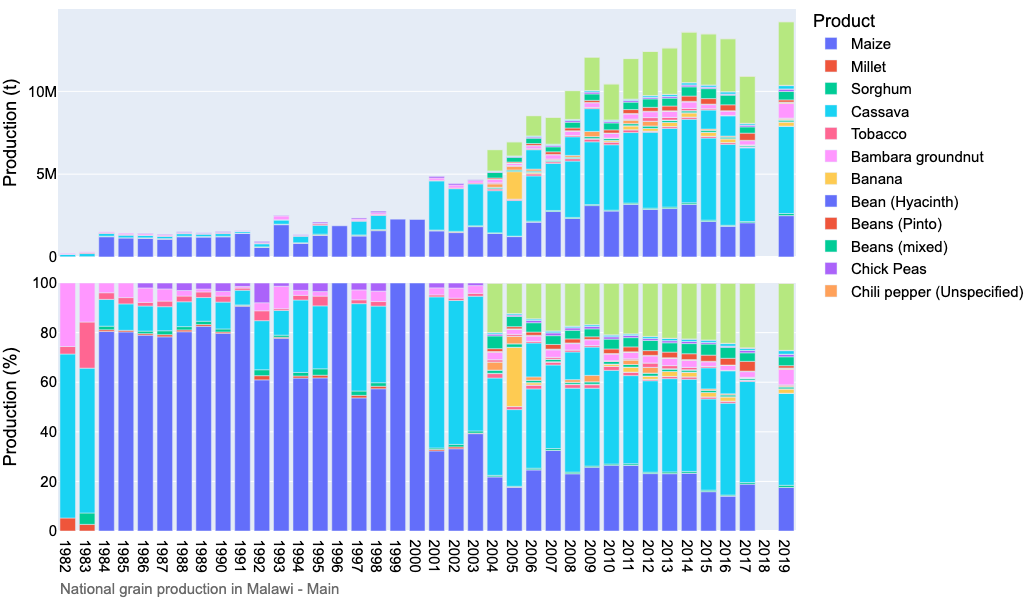

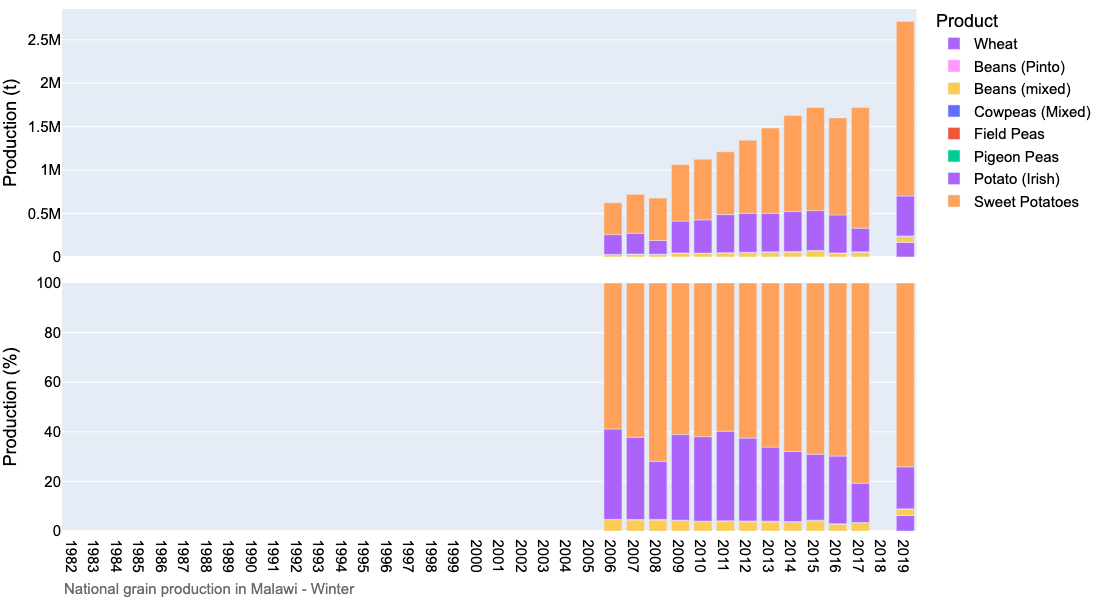

In [7]:
# Bar chart of national grain production
country_iso, country_name = 'MW', 'Malawi'
df = pd.read_csv('../data/crop/adm_crop_production_%s.csv' % country_iso)
df['year'] = df['harvest_year']
year = [df['year'].min(), df['year'].max()]
product_order = ['Maize','Millet','Sorghum','Wheat','Rice','Cassava','Tobacco','Sweet Potato']
for season_name in ['Main','Winter']:
    footnote = 'National grain production in %s - %s' % (country_name, season_name)
    fn_save = '../figures/%s_bar_natgrainprod_%s.png' % (country_iso, season_name)
    sub = df[df['season_name'] == season_name]
    fig = PlotBarProduction(sub, year, product_order, footnote)
    fig.show()

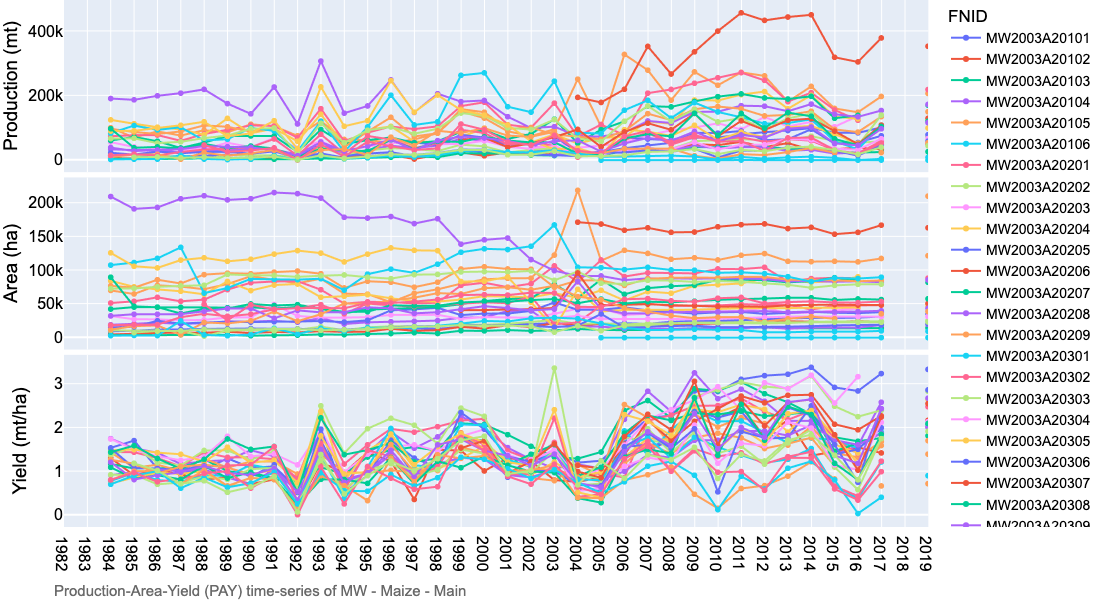

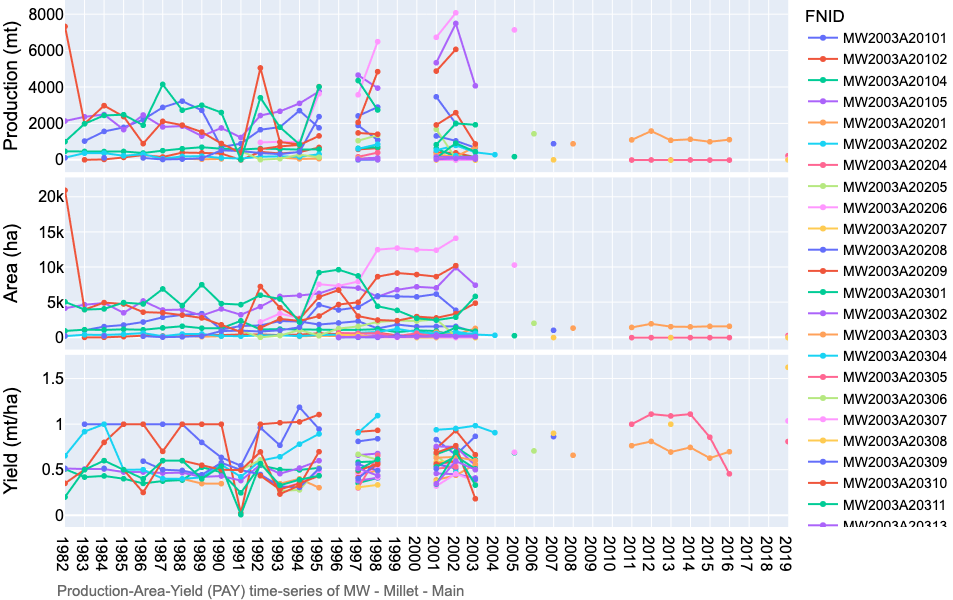

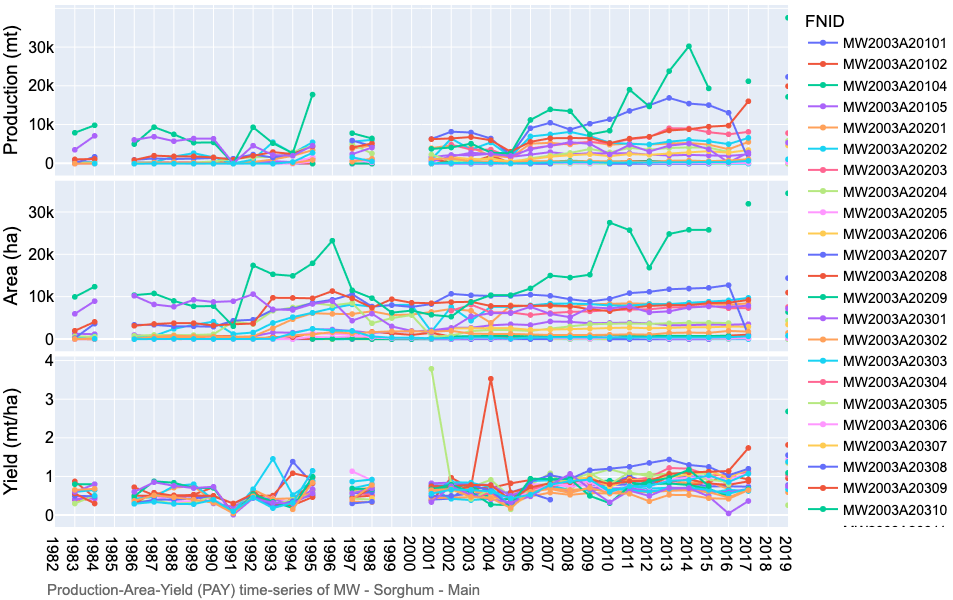

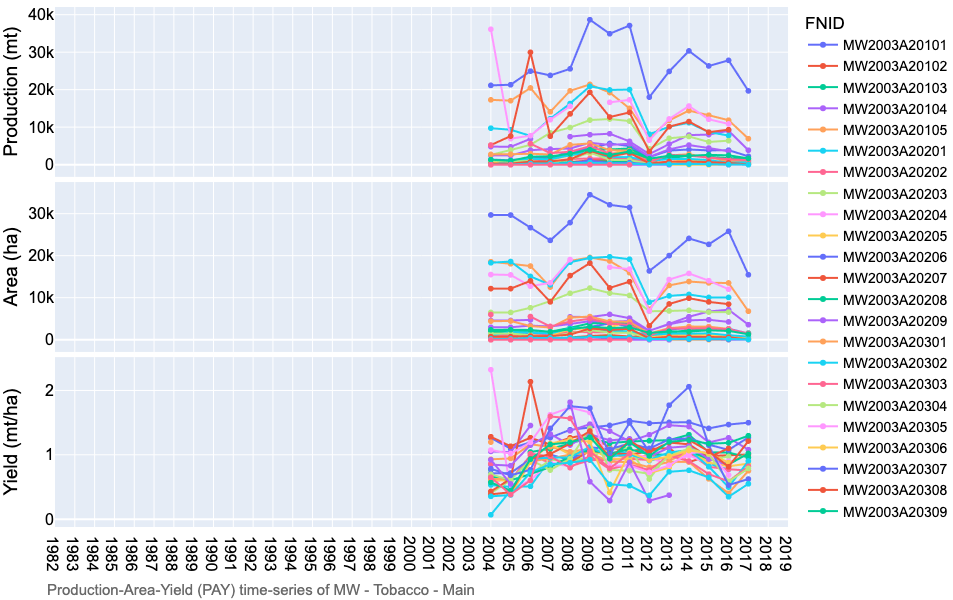

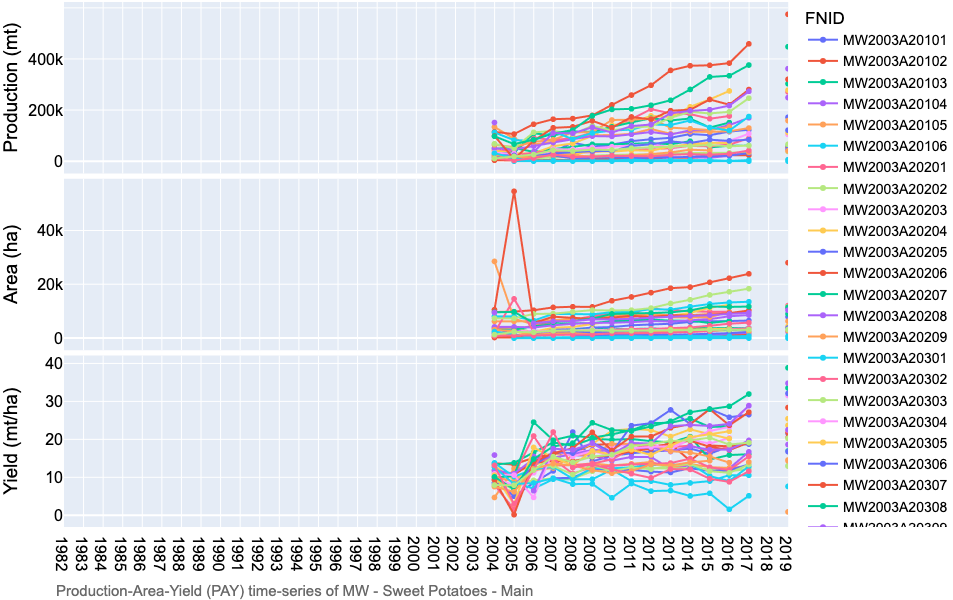

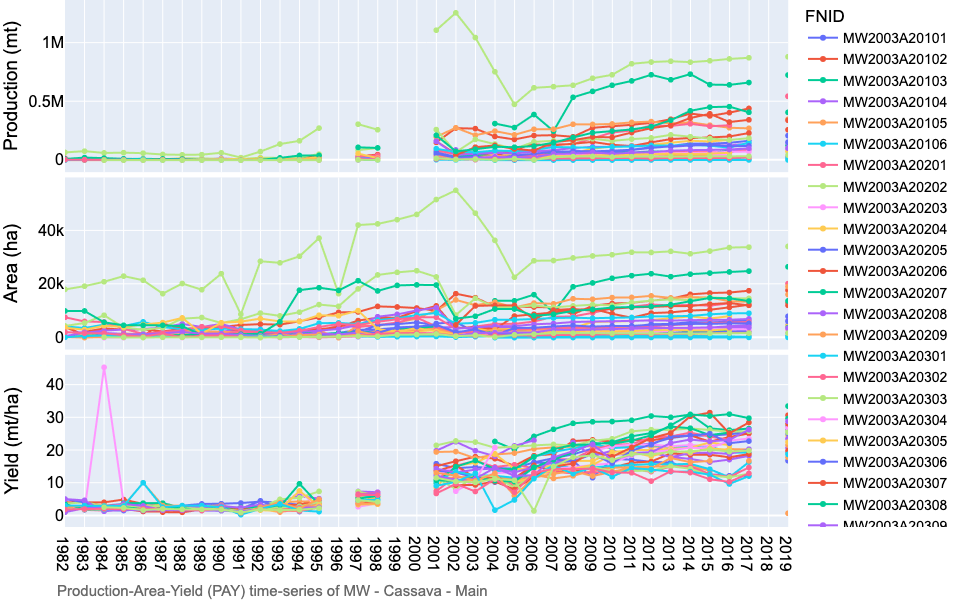

In [8]:
# Lineplot of Production-Area-Yield (PAY) time-series
country_iso, country_name = 'MW', 'Malawi'
df = pd.read_csv('../data/crop/adm_crop_production_%s.csv' % country_iso)
df['year'] = df['harvest_year']
year = [df['year'].min(), df['year'].max()]
product_season = [
    ['Maize','Main'],
    ['Millet','Main'],
    ['Sorghum','Main'],
    ['Tobacco','Main'],
    ['Sweet Potatoes','Main'],
    ['Cassava','Main']
]
for product_name, season_name in product_season:
    footnote = 'Production-Area-Yield (PAY) time-series of %s - %s - %s' % (country_iso, product_name, season_name)
    fn_save = '../figures/%s_line_pay_%s_%s.png' % (country_iso, product_name, season_name)
    sub = df[(df['product'] == product_name) & (df['season_name'] == season_name)]
    fig = PlotLinePAY(sub, year, footnote)
    fig.show()